# Predicting Movie Genre - MA 346 - Prof. Giansiracusa
## Final Project (Due Dec 18, report in PDF/Word and Python code in .py file):

### Data Files
* [ratings.csv](ratings.csv)
* [imdb.csv](imdb.csv)
* [movie data.xlsx](movie_data.xlsx)

### Part I: Counting the genres of highly rated movies/shows, using a web API

In [ ]:
#make the necessary imports
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
import json
import os
from collections import Counter

1.	Read in the file "ratings.csv" and get the "tconst" values for the top 1000 rated movies (or any collection of 1000 movies in this file all with rating 10.0)

In [ ]:
#read in the file as a pandas dataframe
df = pd.read_csv("ratings.csv")

In [ ]:
print(df)

In [ ]:
#sorts the dataframe by average rating, saves it to new varaible
df_sort = df.sort_values(by = ['averageRating'], ascending = False)
#.head() shows the first 10 rows to confirm the sorting worked
df_sort.head()

In [ ]:
#takes the first 1000 rows of the 'tconst' column in our sorted dataframe as a list
tconst_values = list(df_sort['tconst'][:1000])

2.	Request an API key at the following website (a free account allows you to access their data 1000 times per day): http://www.omdbapi.com/
3.	Use this API to download the JSON files for your 1000 movies based on their imdb ID and store this in a list of dictionaries (some these dictionaries will just contain an error message because IMDB could not find the movie you requested, so ignore these and only keep the dictionaries that have some actual movie data in them)

In [ ]:
#create empty list to append data into
calls = []

#iterate through each tconst values
for tconst in tconst_values:
    try:
        #substitute 'tconst' for the actual number each time through the loop to make the request save request object
        #note to run this code you need to cut and paste a new API key because this one is past call limit
        req = requests.get("http://www.omdbapi.com/?i=" + tconst + "&apikey=7a38e92f").text
        #convert the text from the request from JSON format into Python dictionary format
        req_json = json.loads(req)
        #append dictionary to calls list
        calls.append(req_json)
    except:
        #if json.loads(req) throws an error print message
        print("This run failed, call number: " + str(len(calls) + 1))
#prints how many movies have successfully been added to calls list
print(str(len(calls)))

In [ ]:
#converts calls list into a Pandas DataFrame and uses .head() to show first 10 rows
calls = pd.DataFrame(calls)
calls.head(10)

In [ ]:
#Write calls dataframe to csv for reproducability purposes
calls.to_excel("movie data.xlsx")

4.	Count the number of movies in your list for each of the possible values for "Genre" (some movies have multiple genres, if one is tagged as, say, "Drama, Comedy" then I want you to count it as both a Comedy and a Drama, then produce a bar plot showing the number for each genre (for example, it might show 350 Drama, 200 Romance, 500 Comedy, 400 NaN, etc.---it may add up to more than 1000 due to movies tagged as multiple genres, but also you removed the JSON requests with error responses so it may add up to less than 1000).

In [ ]:
genre_dict = {}
drop_indeces = []

#loop through calls and store frequency of film genres in a dictionary
#The IF conditional takes care of unexpected datatypes in the genre column. The first run through failed to execute
#due to float and int typing breaking the .split() method. Indeces are stored to drop these rows from the dataframe.

#TODO: replace for loop with list comprehension

for j, i in enumerate(calls["Genre"]):
    if type(i) == float or type(i) == int:
        drop_indeces.append(j)
    else:
        genres = i.split(", ")
    for i in genres:
        if not i in genre_dict:
            genre_dict[i] = 1
        else:
            genre_dict[i] +=1


print(genre_dict)

In [ ]:
# Utilizes Counter() object to create dictionary of the 3 most common genres
k = Counter(genre_dict)
top_3 = dict(k.most_common(3))

In [ ]:
# Generates a bar plot of the top 5 most common genres

plt.bar(range(len(top_3)), top_3.values(), align="center")
plt.xticks(range(len(top_3)), top_3.keys())
plt.title('Frequencies of Movie Genres')
plt.show()

### Part II: Predicting movie genre from movie descriptions, using text mining on clean data

1.	Read in the file "imdb.csv" as a Pandas data frame, and create a new column in this data frame consisting of the first word appearing in the Genre (so if the Genre for a movie is listed as "Action,Adventure,Sci-Fi" then your new column should have the value "Action")

In [ ]:
# BEGIN CODING SECTION 2# 
imdb_df = pd.read_csv("imdb.csv")

In [ ]:
# Generate list of First Genres
new_cols = [ i.split(",")[0] for i in imdb_df["Genre"]]

# add list to imdb_df
imdb_df["TopGenre"] = new_cols

print(imdb_df)

In [ ]:
# verify that new column was added to the dataframe
labels_list = []
for i in imdb_df['TopGenre']:
    if not i in labels_list:
        labels_list.append(i)
print(labels_list)

2.	Following the text classification example on p386 of Python Handbook, use multinomial Naive Bayes "MultinonialNB" with the "TfidfVectorizer" to transform the text in the "Description" column of your data frame into a feature matrix and use your single-genre column as the target array.  In the example on p386 there is a training data set and a test data set, but for your movie data you have the target variable (the single-genre) for every movie so similar to the Example on p351, for your movie data I want you to use cross-validation to automatically split your data into train and test and to average the accuracy score obtained over these splits.

In [ ]:
# create testing and training dataframes 
Xtrain, Xtest, ytrain, ytest = train_test_split(imdb_df['Description'], imdb_df['TopGenre'], random_state=1)

In [ ]:
# instantiate model object
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [ ]:
model.fit(imdb_df['Description'], imdb_df['TopGenre'])
Xtest_predicted = model.predict(Xtest)
Xtest_predicted = Xtest_predicted.tolist()

In [ ]:
ytest = ytest.tolist()
for i in range(len(ylabels)):
    print(Xtest_predicted[i], ytest[i])

In [ ]:
mat = confusion_matrix(ytest, Xtest_predicted)
print(mat)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels = labels_list, yticklabels = labels_list)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [ ]:
#NOTE: if a model were to be put into production it is recommended that the dataset me modified in order to ensure that the
#      minimum number of members of the least popular class be greater than or equal to the number of splits used in k-fold 
#      cross validation. You could either use a smaller amount of folds or remove the least popular classes until the rule is
#      satisfied.

print('The average accuracy score obtained over 5-fold CV is: ' + 
      str(cross_val_score(model, imdb_df['Description'], imdb_df['TopGenre'], cv=5).mean()))

### Part III: Revenue, runtime, and rating

1.	Continue with the Pandas data frame you read in from "imdb.csv", and create a new column that is the second Genre listed for each movie, if there are at least two genres listed, and if there is only one genre listed then just use that genre (for example, if a movie has Genre "Action,Adventure,Comedy" then you should have a column with value "Action" from before and now a new column with value "Adventure", whereas if a movie has Genre "Action" then both your old and new columns should have value "Action").
2.	Produce a pivot table showing the average Revenue for each value of first genre and second genre (so it should list the average revenue for Action-Action movies, and Action-Adventure movies, and ... etc.)

In [ ]:
#list comprehension to create new column existing of the second genre listed in the "Genre" column for rows with more than one
#value. If there is no second genre the "SecondGenre" column will hold the value of the first and only genre/

imdb_df["SecondGenre"] = [i.split(",")[0] if len(i.split(",")) < 2 else i.split(",")[1] for i in imdb_df["Genre"]]

#creates pivot table to show the mean revenue in millions for every combination of a moves first genre and second genre,
#and first genre if there is only one.

table = pd.pivot_table(imdb_df, 
                    values = "Revenue (Millions)",
                    index = ["TopGenre", "SecondGenre"],
                    aggfunc = np.mean,
                    fill_value=0)

#reshape table via unstack() for improved readability
table.unstack()

3.	Produce a scatter plot showing how Revenue is related to Rating, and include a linear regression best-fit-line in this plot (there's a command to do this automatically, you can use that).

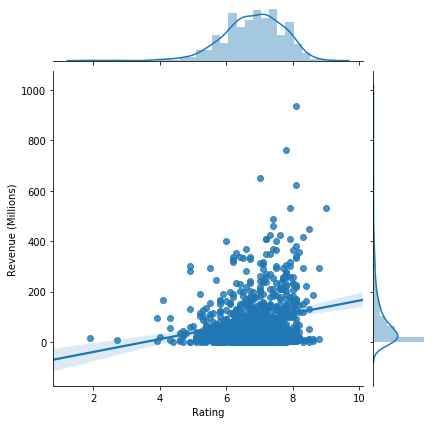

In [114]:
#show relationship between rating and revenue
sns.jointplot('Rating', 'Revenue (Millions)', data=imdb_df, kind='reg')
plt.show()

#TODO: Remove outliers/resize y-axis

4.	Use cross validation to get an average accuracy for predicting the first genre of movies, as you did in Part II, except now use Gaussian Naive Bayes "GaussianNB" instead of multinomial Naive Bayes, and use Revenue, Runtime, and Rating for your predictors instead of text mining the movie descriptions.   

In [ ]:
#instantiate model object
model2 = make_pipeline(GaussianNB())

In [ ]:
#set
predictors = pd.DataFrame(imdb_df[['Revenue (Millions)', 'Runtime (Minutes)', 'Rating']])
predictors['Revenue (Millions)'] = predictors['Revenue (Millions)'].fillna(predictors['Revenue (Millions)'].mean())
print(predictors)
predictors = predictors.to_numpy()
y = imdb_df['TopGenre']


In [ ]:
y.value_counts()

In [ ]:
#NOTE: if a model were to be put into production it is recommended that the dataset me modified in order to ensure that the
#      minimum number of members of the least popular class be greater than or equal to the number of splits used in k-fold 
#      cross validation. You could either use a smaller amount of folds or remove the least popular classes until the rule is
#      satisfied.

model2.fit(predictors,y)
print('The average accuracy score obtained over 5-fold CV is: ' + str(cross_val_score(model2, predictors, y, cv=5).mean()))

# TODO
## Redo assignment for more practice
* Select better data. I.e, filter not just for rating but amount of ratings for data that will produce more meaningful results
* Practice model testing/optimization and aim to improve accuracy metric
* Maybe replicate with a different film API and compare ratings
